In [1]:
import numpy as np
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models, transforms, datasets

import matplotlib.pyplot as plt
import matplotlib.animation as animation

seed = 999
random.seed(seed)
torch.manual_seed(seed)

# Hyper-parameters

In [2]:
img_size = 64
bs = 128
num_workers=1

dim_z = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ngpu = 1

# Import dataset and Load data into batches

In [3]:
data_dir = "./celeba_data"

data_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root=data_dir, transform=data_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=num_workers)

# Display data images

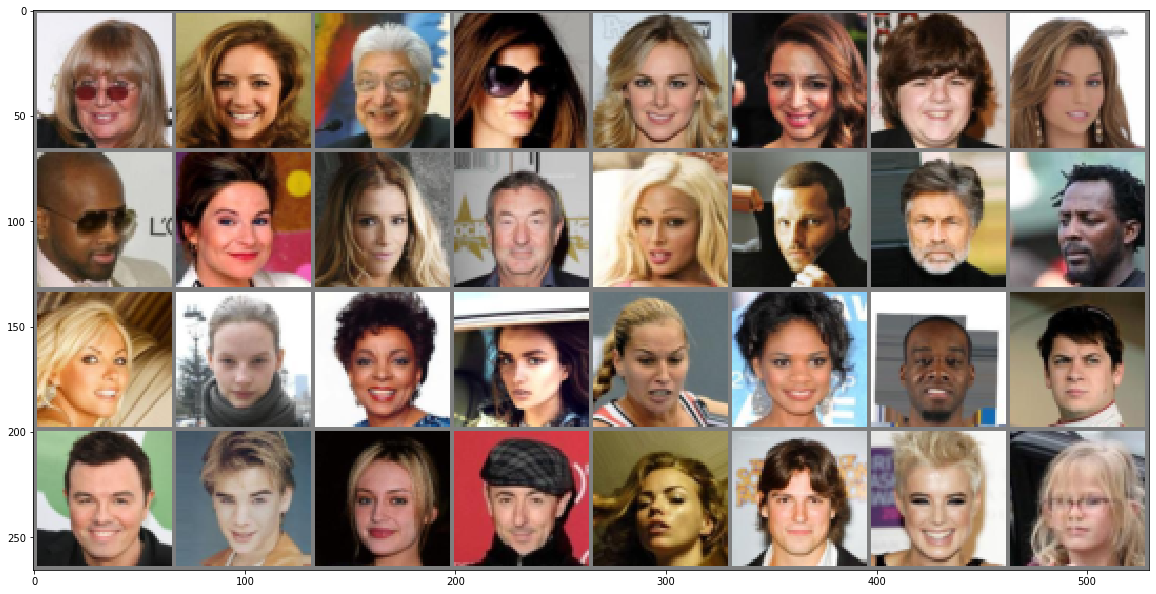

In [4]:
def show_image(img, figsize):
    img = img.numpy().transpose(1,2,0)
    
    mean = np.array([0.5, 0.5, 0.5]) #.reshape((1,1,3)) # bc we have reshaped to HWC
    std = np.array([0.5, 0.5, 0.5]) #.reshape((1,1,3))
    
    img = img * std + mean
    
    plt.figure(figsize = figsize)
    plt.imshow(img)
    
images,_ = next(iter(dataloader))
imgs = torchvision.utils.make_grid(images[:32])
show_image(imgs, figsize=(20,20))

# The Generator class

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        self.structure = nn.Sequential(
            nn.ConvTranspose2d(in_channels=dim_z, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, z):
        return self.structure(z)

# The Discriminator class
* Same padding -> use the formula below:
out = $\lfloor{\frac{in + 2p - k}{s}\rfloor+1}$

In [6]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        self.structure = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, img):
        return self.structure(img)

# Function for weights initialization
* Invoke function **nn.Module(fn: weights_init)** to initialize model's weights

In [7]:
def weights_init(m):
    name = m.__class__.__name__
    
    if (name.find("Conv") != -1):
        nn.init.normal_(m.weight.data, 0., 0.02) # ~N(mean=0, std=0.02)
    elif (name.find("BatchNorm") != -1):
        nn.init.normal_(m.weight.data, 1., 0.02)
        nn.init.constant_(m.bias.data, 0.)

**Initialize the Generator**

In [8]:
model_G = Generator(ngpu=1)

if (device.type == "cuda" and ngpu > 1):
    model_G = nn.DataParallel(model_G, list(range(ngpu)))
    
# Weights initialization
model_G.apply(weights_init)

Generator(
  (structure): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

**Initialize the Discrimiator**

In [9]:
model_D = Discriminator(ngpu=1)

if (device == "cuda" and ngpu > 1):
    model_D = nn.DataParallel(model_D, list(range(ngpu)))
    
# Initialize weights for the Discriminator
model_D.apply(weights_init)

Discriminator(
  (structure): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

# Training Process

In [10]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(model_D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(model_G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [27]:
NUM_EPOCHS = 30
model_D.to(device)
model_G.to(device)
print()

# Start training

In [28]:
for epoch in range(NUM_EPOCHS):
    print(f"Training epoch {epoch+1}") 
    
    for images, _ in iter(dataloader):
        ################# TRAIN DISCRIMINATOR ; D = argmax [log(D(x)) + log(1-D(G(z)))]  #####################    
        # FIRST: Update Discriminator: D = argmax [log(D(x)) + log(1-G(z))]      
        model_D.zero_grad()
        
        # Define log(D(x))
        real_imgs = images.to(device)
        bs = real_imgs.size(0) # batch size
        
        labels = torch.full(size=(bs,), fill_value=1.0, dtype=torch.float, device=device)
        outputs = model_D(real_imgs).view(-1)     
        lossD_real = criterion(outputs, labels)
        lossD_real.backward() # this will be automatically accumulated with lossD_fake in PyTorch
        
        # Define log(1-D(G(z)))
        z = torch.randn(size=(bs, dim_z, 1, 1), device=device, requires_grad=False)
        fake_imgs = model_G(z)
        
        labels.fill_(0.0) # fake images
        outputs = model_D(fake_imgs.detach()).view(-1) 
        lossD_fake = criterion(outputs, labels)
        lossD_fake.backward() # this is automatically accumulated with lossD_real in PyTorch
        
        optimizerD.step()
        
        # Define Discriminator's cumulative loss
        # lossD = lossD_real + lossD_fake
        
        
        ###################### GENERATOR #########################
        
        # SECOND: Update Generator: G = argmax log(D(G(z))) ; want D(G(z)) to be close to 1.0
        model_G.zero_grad()
        
        labels.fill_(1.0)
        outputs = model_D(fake_imgs).view(-1) # now the fake images are given label "real" to optimize G
        lossG = criterion(outputs, labels)
        lossG.backward()
        
        optimizerG.step()
        
print("Done!") 

Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
Training epoch 15
Training epoch 16
Training epoch 17
Training epoch 18


KeyboardInterrupt: 

# Save trained weights

In [29]:
PATH_GEN = "./celeba_gen_1.pth"
torch.save(model_G.state_dict(), PATH_GEN)
PATH_DS = "./celeba_ds_1.pth"
torch.save(model_D.state_dict(), PATH_DS)

# Load saved trained weights (in case you have another weights)

In [21]:
model_G.load_state_dict(torch.load(PATH_GEN))
model_D.load_state_dict(torch.load(PATH_DS))

<All keys matched successfully>

# Execute trained Generator to generate faces

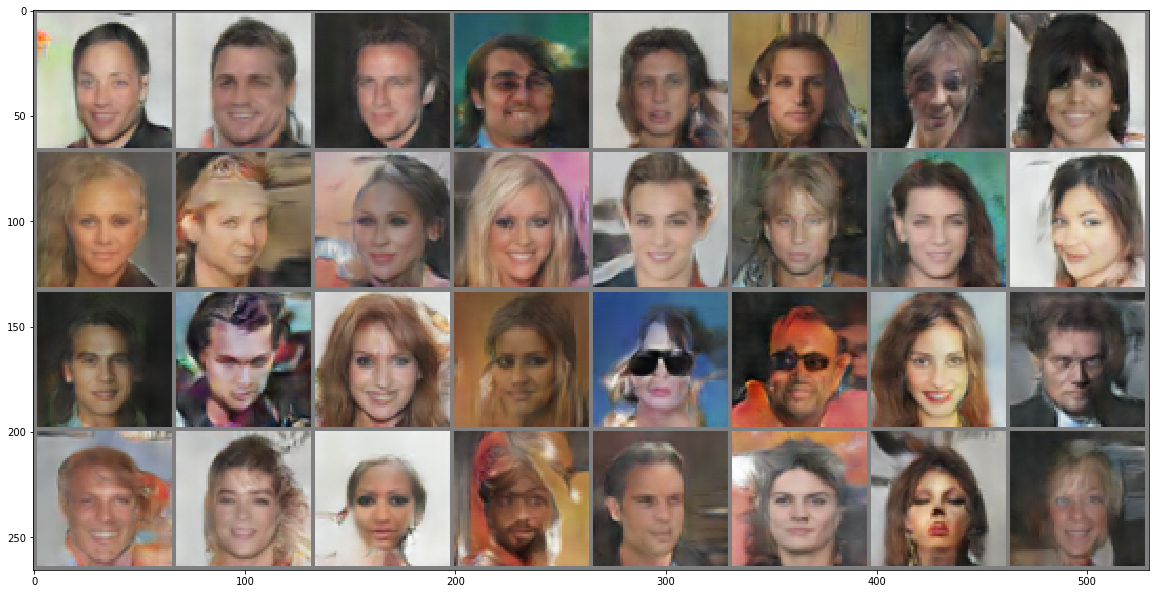

In [33]:
num_gen = 32 # Generate 32 faces
z = torch.randn(size=(num_gen,dim_z,1,1), device=device)
img_gen = model_G(z).detach().cpu()

show_image(torchvision.utils.make_grid(img_gen),figsize=(20,20))

In [63]:
i, data = next(enumerate(dataloader))
images,_ = next(iter(dataloader))

print(data[0].shape)
print(type(data[0]))
print(images.shape)
print(type(images))

torch.Size([128, 3, 64, 64])
<class 'torch.Tensor'>
torch.Size([128, 3, 64, 64])
<class 'torch.Tensor'>


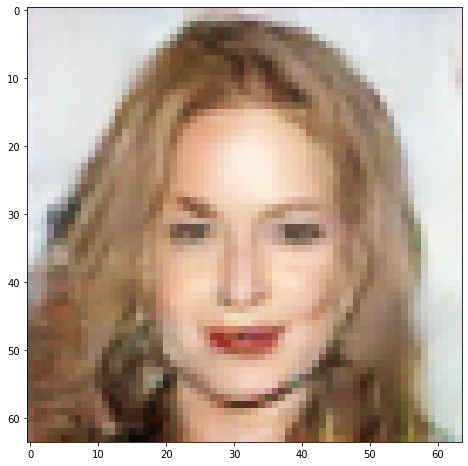

In [331]:
show_image(img_gen[28], figsize=(8,8))

In [317]:
print(model_D(img_gen[0].reshape(1,3,64,64).to(device)))

tensor([[[[0.9381]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [344]:
#show_image(images[5], figsize=(8,8))

In [346]:
torch.save(model_G, "./CelebGenerator.pth")

In [347]:
testModel = torch.load("./CelebGenerator.pth")

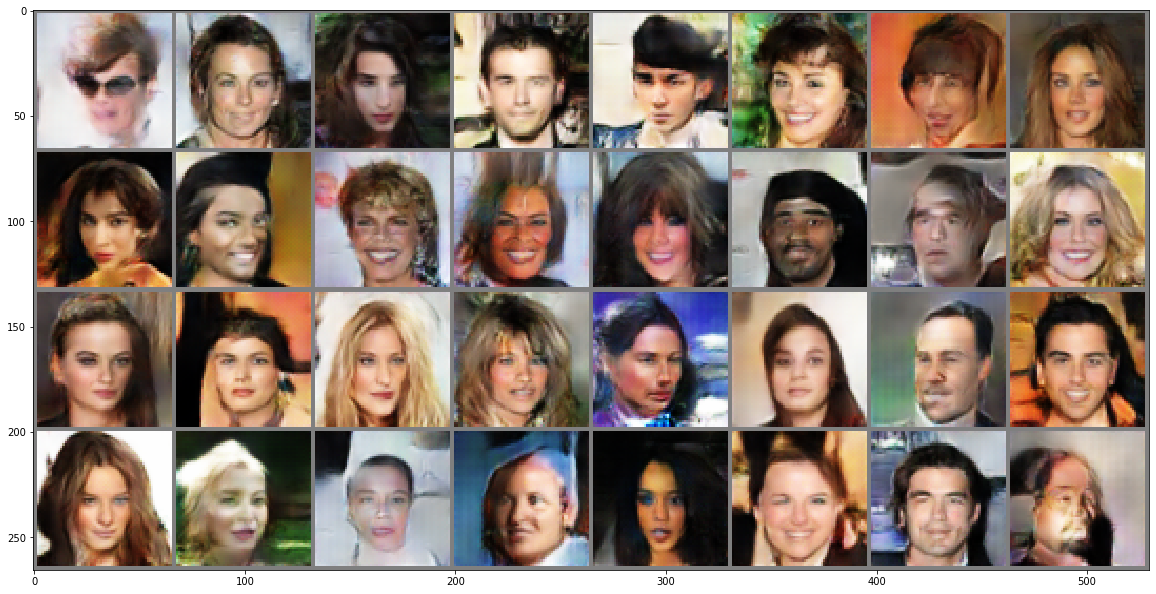

In [348]:
num_gen = 32 # Generate 32 faces
z = torch.randn(size=(num_gen,dim_z,1,1), device=device)
test_gen = testModel(z).detach().cpu()

show_image(torchvision.utils.make_grid(test_gen),figsize=(20,20))